# Proof of Concept (PoC)

Building QMARL with entangled agents.

In [2]:
import cirq
import matplotlib.pyplot as plt
import numpy as np

In [3]:
## Functions to create various entangled input states.

def entangle_agents_phi_plus(qubits, d: int, n: int):
    """Entangles via $\\phi+$."""

    # Entangle the input qubits.
    for i in range(d):
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])


def entangle_agents_psi_plus(qubits, d: int, n: int):
    """Entangles via $\\psi+$."""

    # Entangle the input qubits.
    for i in range(d):
        yield cirq.H(qubits[i])
        for j in range(n-1):
            yield cirq.X(qubits[(j+1)*d + i])
            yield cirq.CNOT(qubits[j*d + i], qubits[(j+1)*d + i])

In [32]:
def agent_policy(qubits, d: int, aidx: int, thetas: np.ndarray = None, return_thetas: bool = False):
    """Agent RL policy circuit."""
    
    if thetas is None:
        thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))
    
    def yield_circuit():
        for i in range(d):
            yield [
                cirq.Rx(rads=thetas[i][0])(qubits[aidx*d + i]),
                cirq.Ry(rads=thetas[i][1])(qubits[aidx*d + i]),
                cirq.Rz(rads=thetas[i][2])(qubits[aidx*d + i]),
                ]
        for i in range(d-1):
            yield cirq.CNOT(qubits[aidx*d + i], qubits[aidx*d + i + 1])
            
    if return_thetas:
        return yield_circuit(), thetas
    else:
        return yield_circuit()

In [8]:
d_qubits = 2 # Number of qubits (dimension) for each agent.
n_agents = 2 # Number of agents.

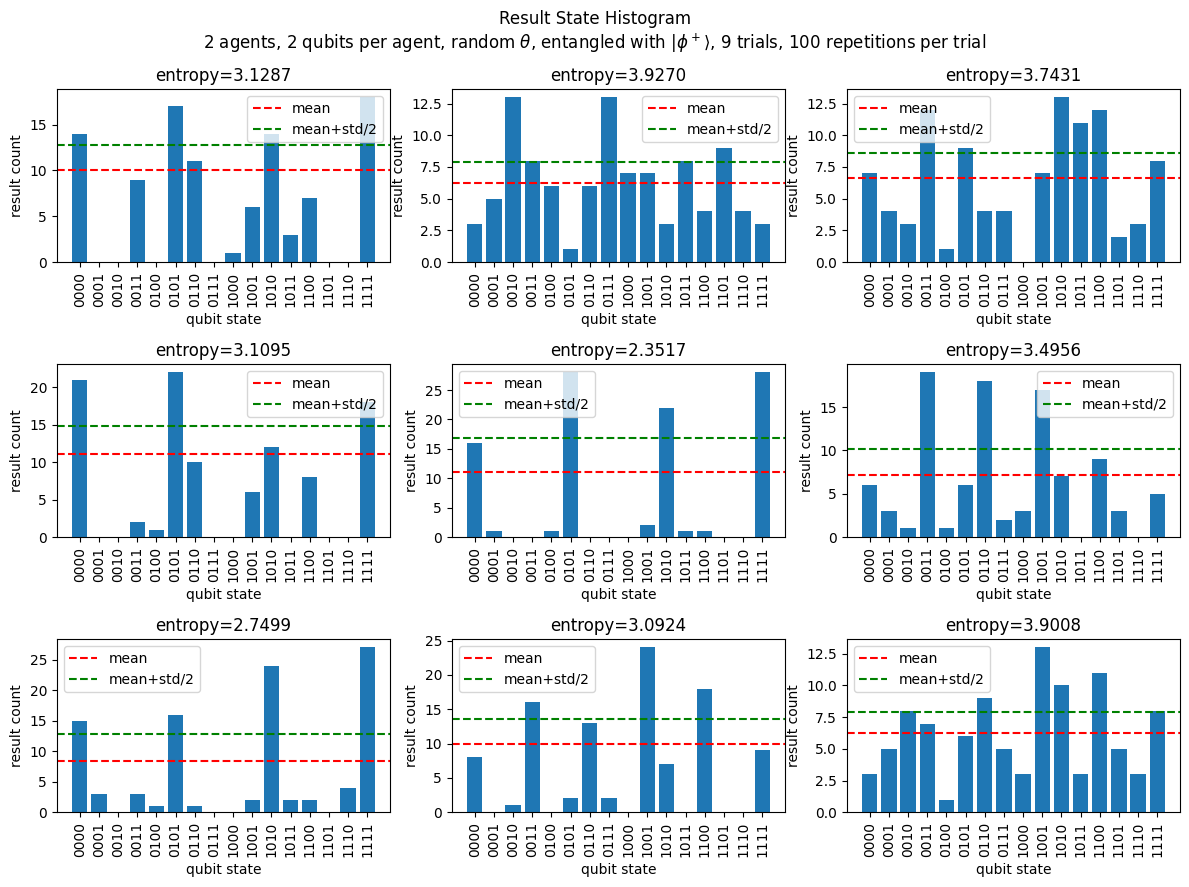

In [33]:

def test_entangled_phi_plus(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, random $\\theta$, entangled with $|\phi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        circuit.append(entangle_agents_phi_plus(qubits, d, n))
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_phi_plus(d_qubits, n_agents);

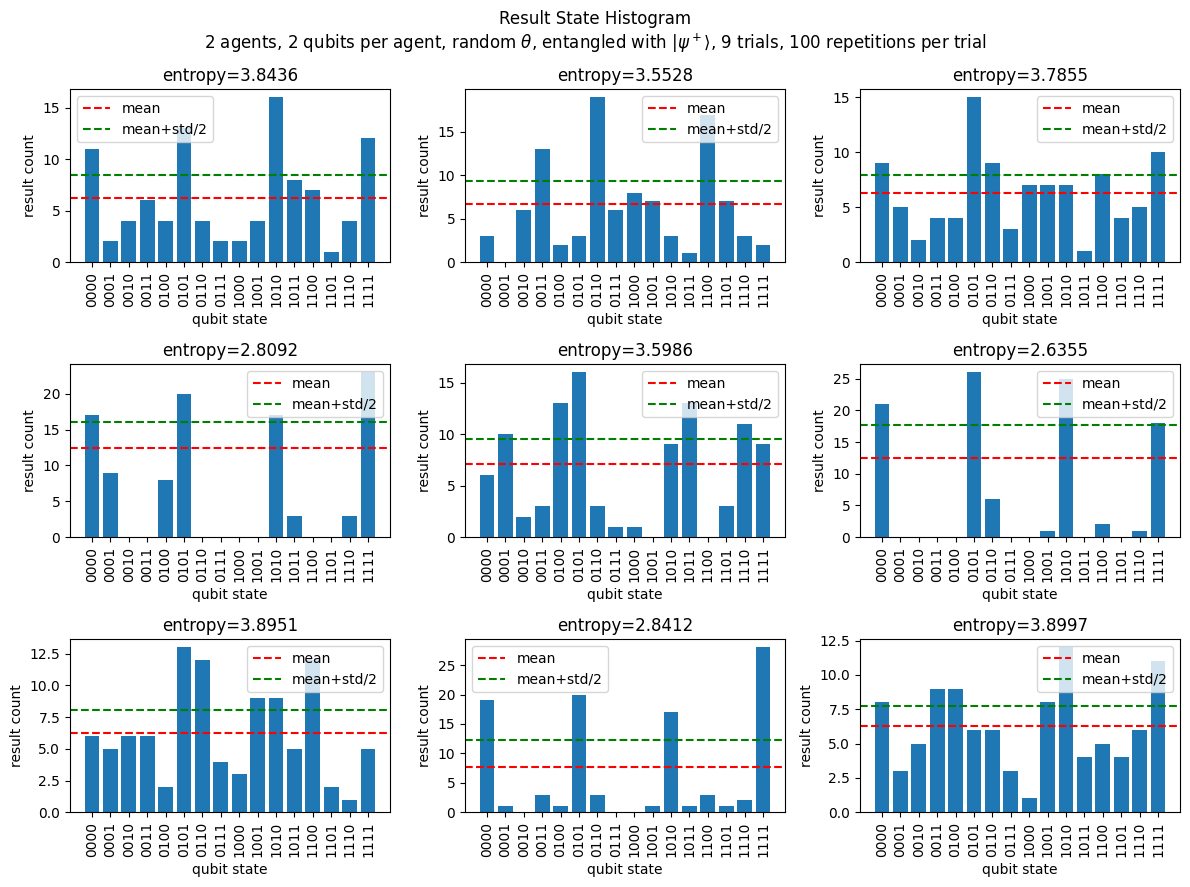

In [25]:

def test_entangled_psi_plus(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, random $\\theta$, entangled with $|\psi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        circuit.append(entangle_agents_psi_plus(qubits, d, n))
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_psi_plus(d_qubits, n_agents);

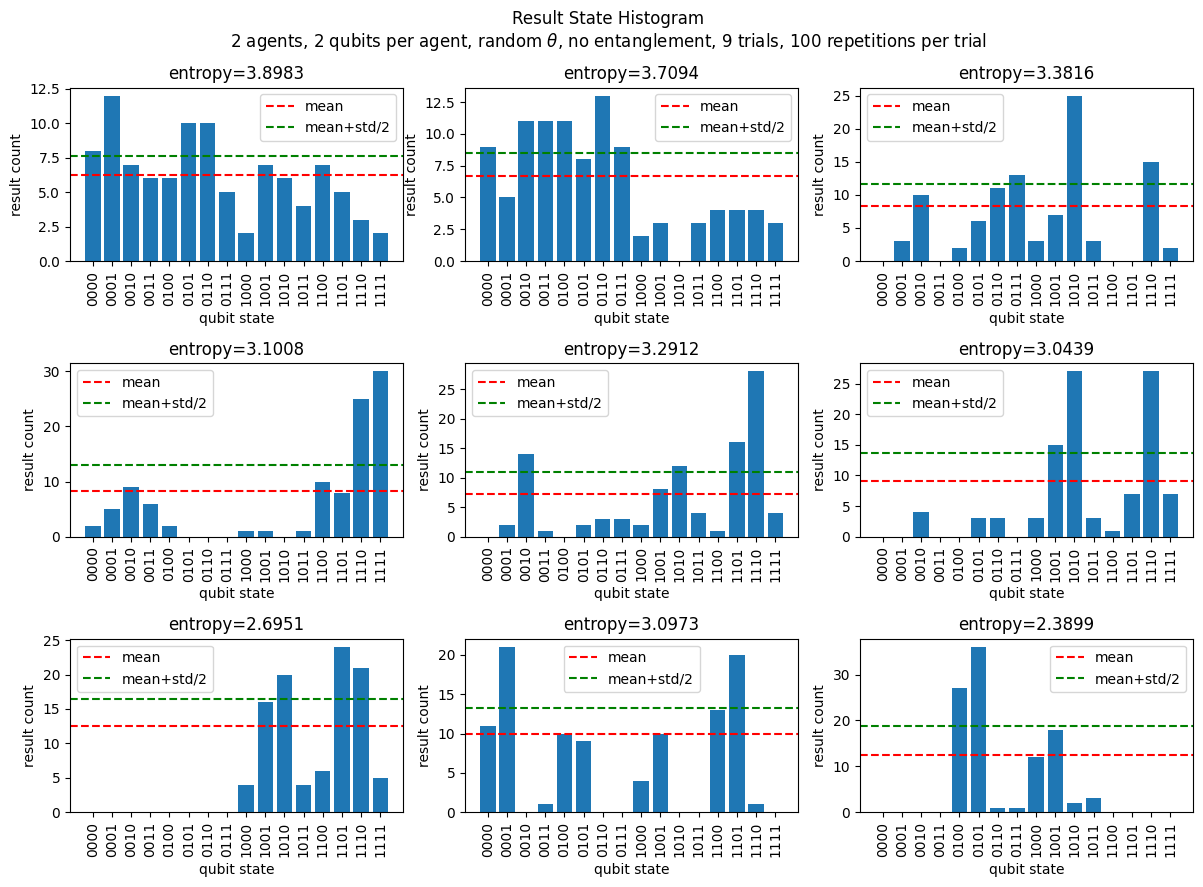

In [31]:

def test_no_entangled(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, random $\\theta$, no entanglement, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_no_entangled(d_qubits, n_agents);

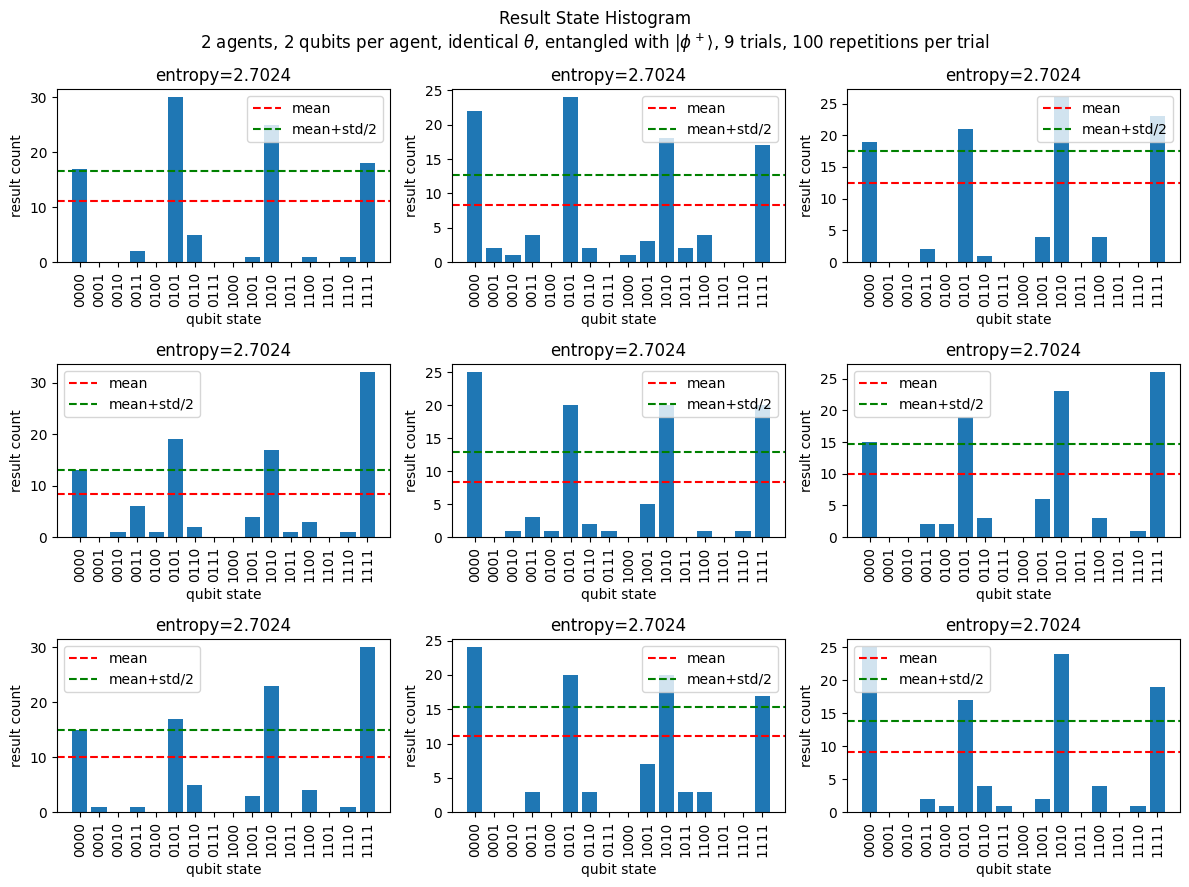

In [36]:

def test_entangled_phi_plus_identical_thetas(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, identical $\\theta$, entangled with $|\phi^+\\rangle$, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()
    
    thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        circuit.append(entangle_agents_phi_plus(qubits, d, n))
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx, thetas=thetas))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_entangled_phi_plus_identical_thetas(d_qubits, n_agents);

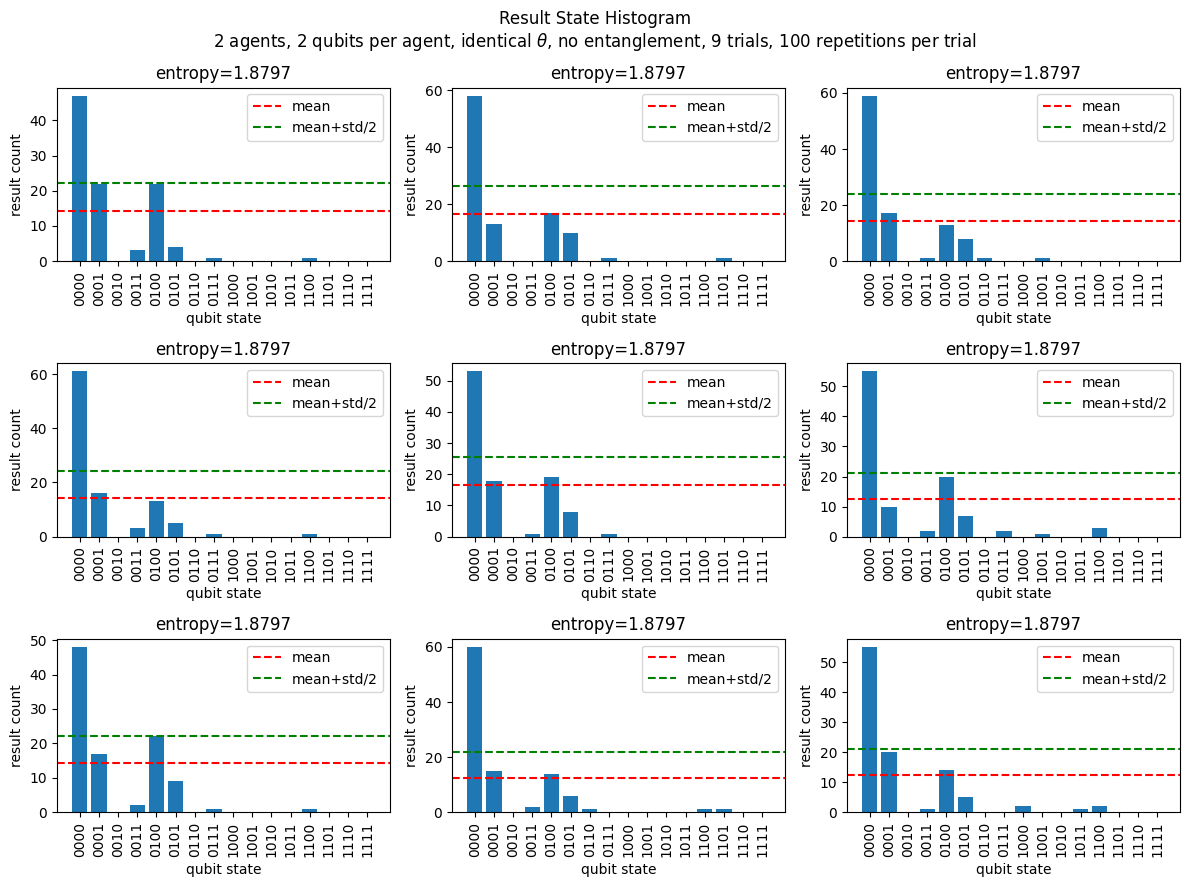

In [35]:

def test_no_entangled_identical_thetas(d: int, n: int, repetitions: int = 100):

    qubits = cirq.LineQubit.range(d * n)


    fig, axs = plt.subplots(3, 3, figsize=(12, 9))
    axs = axs.flatten()
    n_circuits = len(axs)
    fig.suptitle(f'Result State Histogram\n{n} agents, {d} qubits per agent, identical $\\theta$, no entanglement, {len(axs)} trials, {repetitions} repetitions per trial')

    sim = cirq.Simulator()
    
    thetas = np.random.uniform(low=0., high=np.pi, size=(d, 3,))

    for i in range(n_circuits):
        circuit = cirq.Circuit()
        # circuit.append(entangle_agents_phi_plus(qubits, d, n))
        for aidx in range(n):
            circuit.append(agent_policy(qubits, d, aidx, thetas=thetas))
        circuit.append(cirq.measure(qubits, key='actions'))
        
        rho = cirq.final_density_matrix(circuit)
        entropy = cirq.von_neumann_entropy(rho)
        
        samples = sim.run(circuit, repetitions=repetitions)

        cirq.plot_state_histogram(samples, axs[i])
        ctr = samples.histogram(key='actions')
        mean = np.mean([v for k, v in ctr.items()])
        std = np.std([v for k, v in ctr.items()])
        axs[i].axhline(y=mean, color='r', linestyle='--', label='mean')
        axs[i].axhline(y=mean+std/2., color='g', linestyle='--', label='mean+std/2')
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
        axs[i].xaxis.set_major_formatter(lambda x, pos: f"{int(x):0{d*n}b}")
        axs[i].legend()
        axs[i].set_title(f"{entropy=:.4f}")

    fig.tight_layout()
    return fig


test_no_entangled_identical_thetas(d_qubits, n_agents);